# Report

Author: Sofiia Budilova

This report is devoted to exporation of popularity of development environments (or simulators) for UAVs and flight controle software (which also can be called software below).

It was decided to estimate different values by results' amount in Google Scholar, which are listed below:

1. Popularity of an entity **in general** is determined by searching only by name (e.g. "PX4" without parentheses)
2. Popularity of usage of the entity **for UAVs** is determined by searching name + "uav" (e.g. "PX4 uav" without parentheses)

3. To find out **usage of specific simulator with specific flight software**, queries with such structure were used: UAV simulation {flight software name} {simulator name} (e.g. "UAV simulation PX4 gazebo" without parentheses)

Note: You can fill search results from Google Scholar either using code in First Part of this report or manually

#### Table of Contents
1. [First Part: Get Data](#get_data)
2. [Second Part: Retrieving Insites](#retrieving_insites)
    1. [Text Vizualization](#text-vizualization)
    2. [Plot Vizualization](#plot_vizualization)

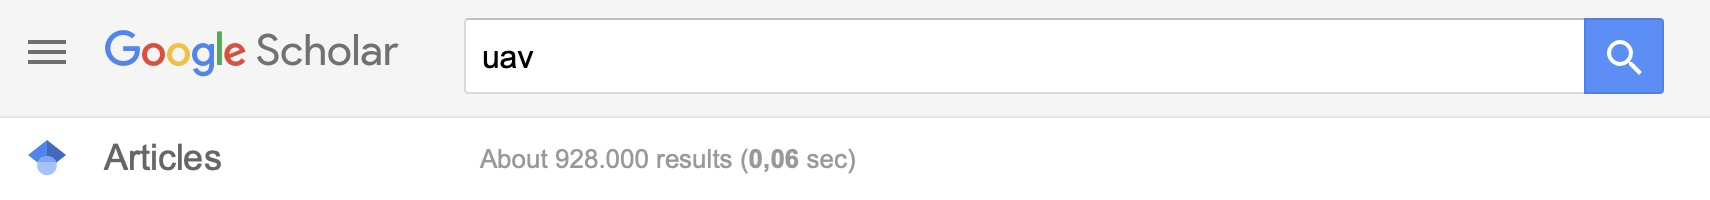

<a id='get_data'></a>

## First Part: Get Data

This section proposes a method to retrieve results' amount from Google Scholar. It is done using BeautifulSoup and webscraping. The method is not fully functioning though because quickly responses to requests start to have code 429 (Too Many Requests).

#### Usage Instuctions

1. Create file named as the variable *'software_names_filename'* in JSON format. There is default value of the variable which can be changed. Add an array of software names there.
2. Similarly, create file named as the variable *'sim_names_filename'* in JSON format. Add an array of simulators' names there.
2. Similarly, create file named as the variable *'data_filename'* in JSON format. Add a structure similar to given in "flight_software_sims_data_template.json".

Note: Clear the given in "flight_software_sims_data_template.json" fields.

In [64]:
from bs4 import BeautifulSoup
import requests
import re
import time
import json
from utils import add_key_to_dict

In [65]:
software_names_filename = "flight_software_list"
sim_names_filename = "simulators_list"
data_filename = "flight_software_sims_data_test"

In [66]:
def get_search_result_from_google_scholar(request: str) -> int:
    time.sleep(5)
    
    url = f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q={"+".join(request.split(" "))}&btnG="
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text)
        res = re.search(r"About (\d*)[.](\d*) result[s] \(\d*[,]\d* sec\)", soup.text)

        if res:
            about_results_string = soup.text[res.start():res.end()] # About 3.550 results (0,09 sec)
            res =  int(about_results_string.split(" ")[1].replace(".", "")) # 3550
            print(f"Got result for request '{request}'")
            return res
        else:
            no_results_found_match = re.search(r"Your search - \S+ - did not match any articles.", soup.text)
            if no_results_found_match:
                print(f"Got result (0) for request '{request}'")
                return 0
            else:
                print(f"Unknown error occured, could not parse the result (request '{request}'), response: {response}")
                return None
    else:
        print(f"Could not find url: {url}, response: {response}")
        print(f"Given request: '{request}'")
        return None

In [67]:
def get_flight_software_names():
    with open('flight_software_list.json') as f:
        names = json.load(f)
        print("Loaded flight software names successfully")
        return names
    
def get_simulators_names():
    with open("simulators_list.json") as f:
        names = json.load(f)
        print("Loaded simulators names successfully")
        return names

def get_flight_software_sims_data():
    with open(f"{data_filename}.json") as f:
        data = json.load(f)
        print("Loaded flight software and simulators data successfully")
        return data

In [68]:
def add_popularity(name: str, is_software: bool, existing_data: dict):
    entity = "software" if is_software else "sim"

    overall_result = get_search_result_from_google_scholar(name)
    if overall_result:
        existing_data[f"{entity}_popularities"][name] = overall_result
        print("Added overall popularity of " + name)

    uav_result = get_search_result_from_google_scholar(name + " uav")
    if uav_result:
        existing_data[f"uav_{entity}_popularities"][name] = uav_result
        print("Added UAV popularity of " + name)
    
    else:
        print("An error occured while adding popularity of " + name)
        if not overall_result:
            print(f"Overall result of {name} not found")
        if not uav_result:
            print(f"UAV result of {name} not found")

In [69]:
def add_software_and_sim_usage(sim: str, software: str, existing_data: dict):
    res = get_search_result_from_google_scholar(f"UAV simulation {software} {sim}")
    if res:
        existing_data["soft_sim_distributions"][software][sim] = res
        print(f"Added distibution of {software} with {sim}")
    else:
        print(f"Could not add distibution of {software} with {sim}")

In [70]:
def add_data_about_soft_and_sims(only_add_new=True):
    software = get_flight_software_names()
    sims = get_simulators_names()
    existing_data = get_flight_software_sims_data()

    keys = [
        "software_popularities",
        "sim_popularities",
        "uav_software_popularities",
        "uav_sim_popularities",
        "soft_sim_distributions",
    ]
    for key in keys:
        add_key_to_dict(key, existing_data)

    for soft in software:
        if (
            not only_add_new
            or soft not in existing_data["software_popularities"].keys()
        ):
            add_popularity(soft, is_software=True, existing_data=existing_data)
        if (
            not only_add_new
            or soft not in existing_data["soft_sim_distributions"].keys()
        ):
            existing_data["soft_sim_distributions"][soft] = {}

        for sim in sims:
            if not only_add_new or soft not in existing_data["sim_popularities"].keys():
                add_popularity(sim, is_software=False, existing_data=existing_data)
            if (
                not only_add_new
                or sim not in existing_data["soft_sim_distributions"][soft].keys()
            ):
                add_software_and_sim_usage(sim, soft, existing_data)

    with open(f"{data_filename}.json", "w") as f:
        json.dump(existing_data, f)

    print(f"Saved received data to {data_filename}.json")
    print("End")

In [72]:
add_data_about_soft_and_sims()

Loaded flight software names successfully
Loaded simulators names successfully
Loaded flight software and simulators data successfully
Could not find url: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=PX4&btnG=, response: <Response [429]>
Given request: 'PX4'
Could not find url: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=PX4+uav&btnG=, response: <Response [429]>
Given request: 'PX4 uav'
An error occured while adding popularity of PX4
Overall result of PX4 not found
UAV result of PX4 not found
Could not find url: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=Gazebo&btnG=, response: <Response [429]>
Given request: 'Gazebo'
Could not find url: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=Gazebo+uav&btnG=, response: <Response [429]>
Given request: 'Gazebo uav'
An error occured while adding popularity of Gazebo
Overall result of Gazebo not found
UAV result of Gazebo not found
Could not find url: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C

<a id='retrieving_insites'></a>

## Second Part: Retrieving Insites and Vizualizing

<a id='text_vizualization'></a>
### Text Vizualization

In this section there is given a textual representation of information found.

#### Usage Instructions

1. Create file named as the variable *'data_filename'* in **class Data** in JSON format. There is default value of the variable which can be changed.

In [5]:
import enum
from utils import sorted_tuples_list

In [6]:
class Data:
    data_filename = "flight_software_sims_data.json"

    def __init__(self):
        with open(self.data_filename) as f:
            dict = json.load(f)

        self.Flight_Software = enum.Enum('DynamicEnum', {k: k for k in dict["software_popularities"]})
        self.Simulator = enum.Enum('DynamicEnum', {k: k for k in dict["sim_popularities"]})
        

        self.software_popularities = {}
        if "software_popularities" in dict.keys():
            for software, value in dict["software_popularities"].items():
                self.software_popularities[self.Flight_Software[software]] = value
        else:
            print("There are no software_popularities in given dict")

        self.sim_popularities = {}
        if "sim_popularities" in dict.keys():
            for sim, value in dict["sim_popularities"].items():
                self.sim_popularities[self.Simulator[sim]] = value
        else:
            print("There are no sim_popularities in given dict")


        self.uav_software_popularities = {}
        if "uav_software_popularities" in dict.keys():
            for software, value in dict["uav_software_popularities"].items():
                self.uav_software_popularities[self.Flight_Software[software]] = value
        else:
            print("There are no uav_software_popularities in given dict")

        self.uav_sim_popularities = {}
        if "uav_sim_popularities" in dict.keys():
            for sim, value in dict["uav_sim_popularities"].items():
                self.uav_sim_popularities[self.Simulator[sim]] = value
        else:
            print("There are no uav_sim_popularities in given dict")

        self.soft_sim_distributions = {}
        if "soft_sim_distributions" in dict.keys():
            for software, dict_value in dict["soft_sim_distributions"].items():
                self.soft_sim_distributions[self.Flight_Software[software]] = {}
                for sim, value in dict_value.items():
                    self.soft_sim_distributions[self.Flight_Software[software]][self.Simulator[sim]] = value
        else:
            print("There are no soft_sim_distributions in given dict")


In [7]:
data = Data()

In [9]:
def get_sim_usage_for_uavs(simulator, data: Data):
    return round(data.uav_sim_popularities[simulator] / data.sim_popularities[simulator] * 100)

In [10]:
def get_software_usage_for_uavs(flight_software, data: Data):
    return round(
        data.uav_software_popularities[flight_software]
        / data.software_popularities[flight_software]
        * 100
    )

In [11]:
def get_usages_for_uavs_for_all_simulators(data: Data):
    usages = map(
        lambda simulator: (simulator, get_sim_usage_for_uavs(simulator, data)),
        data.Simulator,
    )
    return sorted(usages, key=lambda tup: tup[1], reverse=True)

In [12]:
def usage_of_flight_software(flight_software, simulator, data: Data):
    return round(
        (
            data.soft_sim_distributions[flight_software][simulator]
            / data.uav_sim_popularities[simulator]
        )
        * 100,
    )

In [13]:
def usage_of_simulator(simulator, flight_software, data: Data):
    return round(
        (
            data.soft_sim_distributions[flight_software][simulator]
            / data.uav_software_popularities[flight_software]
        )
        * 100,
    )

In [15]:
def get_popularities_of_softwares(simulator, data: Data):
    popularities = map(
        lambda software: (software, usage_of_flight_software(software, simulator, data)),
        data.Flight_Software,
    )
    popularities = sorted(popularities, key=lambda tup: tup[1], reverse=True)
    return popularities

In [16]:
def get_popularities_for_all_simulators(data: Data):
    return list(
        map(
            lambda simulator: (simulator, get_popularities_of_softwares(simulator, data)),
            data.Simulator,
        )
    )

In [17]:
def pretty_print_popularities_of_software(popularities):
    for software, percent in popularities:
        print(f"{software.value}: {percent}%")


In [18]:
def pretty_print_popularities_of_simulators(popularities):
    for simulator, percent in popularities:
        print(f"{simulator.value}: {percent}%")

In [19]:
def get_popularities_of_simulators(software, data: Data):
    popularities = map(
        lambda simulator: (simulator, usage_of_simulator(simulator, software, data)),
        data.Simulator,
    )
    popularities = sorted(popularities, key=lambda tup: tup[1], reverse=True)
    return popularities

In [20]:
def get_popularities_for_all_softwares(data: Data):
    return list(
        map(
            lambda software: (
                software,
                get_popularities_of_simulators(software, data),
            ),
            data.Flight_Software,
        )
    )

In [28]:
def pretty_print_popularities_for_all_simulators(simulators_popularity, software_popularities_for_simulators):
    simulator_popularities = sorted_tuples_list(simulators_popularity)
    for simulator, popularity in simulator_popularities:
        print(
            f"{simulator.value} ({popularity} mentions overall, with {get_sim_usage_for_uavs(simulator, data)}% mentions with UAVs)"
        )
        softwares = next(
            filter(
                lambda tup: tup[0] == simulator, software_popularities_for_simulators
            ),
        )[1]
        pretty_print_popularities_of_software(softwares)
        print()

In [35]:
def pretty_print_popularities_for_all_softwares(flight_softwares_popularity, simulator_popularities_for_softwares):
    popularities = sorted_tuples_list(flight_softwares_popularity)
    for software, popularity in popularities:
        print(
            f"Flight control software {software.value}: {popularity} mentions overall, with {get_software_usage_for_uavs(software, data)}% mentions with UAVs"
        )
        simulators = next(
            filter(
                lambda tup: tup[0] == software, simulator_popularities_for_softwares
            ),
        )[1]
        pretty_print_popularities_of_simulators(simulators)
        print()

In [23]:
def pretty_print_uav_popularities_for_all_softwares(flight_softwares_uav_popularity):
    popularities = sorted_tuples_list(flight_softwares_uav_popularity)
    for software, popularity in popularities:
        print(
            f"Flight control software {software.value}: {popularity} mentions with UAVs"
        )
    print()

In [24]:
def pretty_print_uav_popularities_for_all_simulators(sim_uav_popularity):
    popularities = sorted_tuples_list(sim_uav_popularity)
    for simulator, popularity in popularities:
        print(f"Simulator {simulator.value}: {popularity} mentions with UAVs")
    print()


In [38]:
sim_popularities = get_popularities_for_all_simulators(data)
software_popularities = get_popularities_for_all_softwares(data)

In [36]:
pretty_print_popularities_for_all_simulators(data.sim_popularities, sim_popularities)

Isaac Sim (371000 mentions overall, with 1% mentions with UAVs)
ArduPilot: 5%
PX4: 4%
INAV: 0%
BetaFlight: 0%

Gazebo (71600 mentions overall, with 14% mentions with UAVs)
PX4: 34%
ArduPilot: 23%
INAV: 1%
BetaFlight: 1%

NVIDIA Isaac Sim (6870 mentions overall, with 7% mentions with UAVs)
PX4: 13%
ArduPilot: 9%
BetaFlight: 2%
INAV: 0%

AirSim (5600 mentions overall, with 47% mentions with UAVs)
PX4: 25%
ArduPilot: 13%
INAV: 1%
BetaFlight: 1%

Microsoft AirSim (1950 mentions overall, with 58% mentions with UAVs)
PX4: 32%
ArduPilot: 17%
BetaFlight: 2%
INAV: 1%

Flightmare (323 mentions overall, with 74% mentions with UAVs)
PX4: 38%
ArduPilot: 13%
BetaFlight: 8%
INAV: 0%



In [37]:
pretty_print_popularities_for_all_softwares(
    data.software_popularities, software_popularities
)

Flight control software PX4: 15900 mentions overall, with 45% mentions with UAVs
Gazebo: 50%
AirSim: 9%
Microsoft AirSim: 5%
Flightmare: 1%
Isaac Sim: 1%
NVIDIA Isaac Sim: 1%

Flight control software ArduPilot: 9930 mentions overall, with 80% mentions with UAVs
Gazebo: 30%
AirSim: 4%
Microsoft AirSim: 2%
Isaac Sim: 1%
NVIDIA Isaac Sim: 1%
Flightmare: 0%

Flight control software INAV: 9110 mentions overall, with 4% mentions with UAVs
Gazebo: 13%
AirSim: 4%
Microsoft AirSim: 3%
Flightmare: 0%
Isaac Sim: 0%
NVIDIA Isaac Sim: 0%

Flight control software BetaFlight: 581 mentions overall, with 73% mentions with UAVs
Gazebo: 19%
AirSim: 9%
Microsoft AirSim: 5%
Flightmare: 4%
Isaac Sim: 2%
NVIDIA Isaac Sim: 2%



In [40]:
pretty_print_uav_popularities_for_all_simulators(data.uav_sim_popularities)

Simulator Gazebo: 10300 mentions with UAVs
Simulator AirSim: 2650 mentions with UAVs
Simulator Isaac Sim: 2250 mentions with UAVs
Simulator Microsoft AirSim: 1140 mentions with UAVs
Simulator NVIDIA Isaac Sim: 502 mentions with UAVs
Simulator Flightmare: 238 mentions with UAVs



In [42]:
pretty_print_uav_popularities_for_all_softwares(data.uav_software_popularities)

Flight control software ArduPilot: 7950 mentions with UAVs
Flight control software PX4: 7100 mentions with UAVs
Flight control software BetaFlight: 422 mentions with UAVs
Flight control software INAV: 405 mentions with UAVs



<a id="plot_vizualization"></a>
### Plot Vizualization

In this section there is given a visual representation of information found and written in the JSON file.

#### Usage Instructions

1. Create file named as the variable *'data_filename'* in **class Data** in [Text Vizualization](#text_vizualization) in JSON format. There is default value of the variable which can be changed.

In [44]:
from utils import sorted_tuples_list
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [45]:
data = Data()

In [60]:
sim_uav_popularity_list = sorted_tuples_list(data.uav_sim_popularities)
simulators_data = list(
    map(
        lambda tup: (
            tup[0],
            tup[1],
            next(filter(lambda x: x[0] == tup[0], sim_uav_popularity_list))[1],
        ),
        sorted_tuples_list(data.sim_popularities),
    )
)
simulators_data = [(tup[0].value, tup[1], tup[2]) for tup in simulators_data]

flight_softwares_uav_popularity_list = sorted_tuples_list(
    data.uav_software_popularities
)
software_data = list(
    map(
        lambda tup: (
            tup[0],
            tup[1],
            next(
                filter(lambda x: x[0] == tup[0], flight_softwares_uav_popularity_list)
            )[1],
        ),
        sorted_tuples_list(data.software_popularities),
    )
)
software_data = [(tup[0].value, tup[1], tup[2]) for tup in software_data]


def get_software_in_simulators():
    simulator_totals = {
        sim: sum(
            softwares.get(sim, 0) for softwares in data.soft_sim_distributions.values()
        )
        for sim in data.Simulator
    }

    software_in_simulators = {"Simulator": [sim.value for sim in data.Simulator]}
    for software in data.soft_sim_distributions:
        software_in_simulators[f"{software.value} (%)"] = []

    for sim in data.Simulator:
        for software, software_data in data.soft_sim_distributions.items():
            percentage = (
                (software_data.get(sim, 0) / simulator_totals[sim]) * 100
                if simulator_totals[sim] > 0
                else 0
            )
            software_in_simulators[f"{software.value} (%)"].append(round(percentage))

    return software_in_simulators


def get_software_in_simulators_absolute():
    software_in_simulators = {"Simulator": [sim.value for sim in data.Simulator]}

    for software in data.soft_sim_distributions:
        software_in_simulators[f"{software.value} (Count)"] = []

    for sim in data.Simulator:
        for software, software_data in data.soft_sim_distributions.items():
            count = software_data.get(sim, 0)
            software_in_simulators[f"{software.value} (Count)"].append(count)

    return software_in_simulators


def get_simulators_in_software():
    software_totals = {
        software: sum(sim_data.values())
        for software, sim_data in data.soft_sim_distributions.items()
    }

    simulators_in_software = {
        "Software": [software.value for software in data.Flight_Software]
    }

    for sim in data.Simulator:
        simulators_in_software[f"{sim.value} (in %)"] = []

    for software, sim_data in data.soft_sim_distributions.items():
        for sim in data.Simulator:
            percentage = (
                (sim_data.get(sim, 0) / software_totals[software]) * 100
                if software_totals[software] > 0
                else 0
            )
            simulators_in_software[f"{sim.value} (in %)"].append(round(percentage))

    return simulators_in_software


def get_simulators_in_software_absolute():
    simulators_in_software = {
        "Software": [software.value for software in data.Flight_Software]
    }

    for sim in data.Simulator:
        simulators_in_software[f"{sim.value} (Count)"] = []

    for _, sim_data in data.soft_sim_distributions.items():
        for sim in data.Simulator:
            count = sim_data.get(sim, 0)
            simulators_in_software[f"{sim.value} (Count)"].append(count)

    return simulators_in_software


simulators_df = pd.DataFrame(
    simulators_data, columns=["Simulator", "Overall Mentions", "UAV Mentions"]
)
software_df = pd.DataFrame(
    software_data, columns=["Software", "Overall Mentions", "UAV Mentions"]
)


folder_to_save_plots = "flight software and sims visualizations"
width = 0.4

In [47]:
def bar_chart_flight_software_by_overall_and_uav_mentions():
    plt.figure(figsize=(8, 5))
    x = np.arange(len(software_df["Software"]))
    plt.bar(
        x - width / 2, software_df["Overall Mentions"], width, label="Overall Mentions"
    )
    plt.bar(x + width / 2, software_df["UAV Mentions"], width, label="UAV Mentions")

    plt.xticks(x, software_df["Software"], rotation=45)
    plt.ylabel("Mentions (log scale)")
    plt.yscale("log")
    plt.title("Flight Control Software: Overall vs UAV Mentions")
    plt.legend()
    plt.tight_layout()
    plt.savefig(
        f"{folder_to_save_plots}/Flight Control Software: Overall vs UAV Mentions.png"
    )

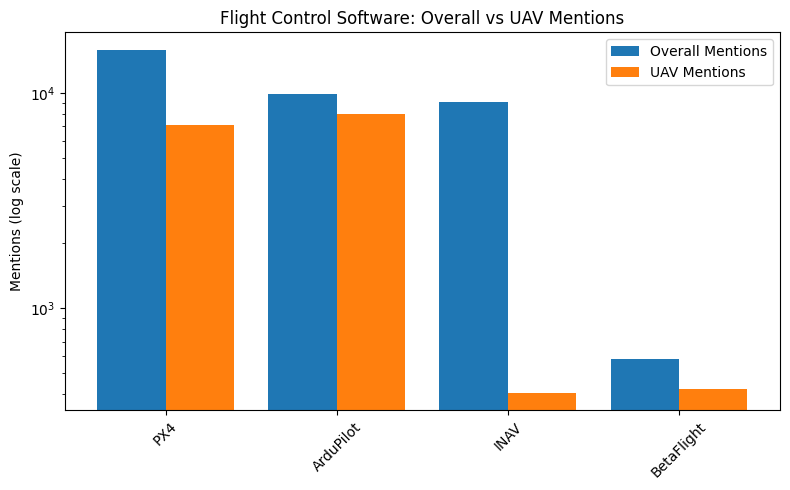

In [48]:
bar_chart_flight_software_by_overall_and_uav_mentions()

PX4 and ArduPilot are the most popular and primarily used for UAVs.

In [50]:
def bar_chart_sims_by_overall_and_uav_mentions():
    plt.figure(figsize=(10, 6))
    x = np.arange(len(simulators_df["Simulator"]))
    plt.bar(
        x - width / 2,
        simulators_df["Overall Mentions"],
        width,
        label="Overall Mentions",
    )
    plt.bar(x + width / 2, simulators_df["UAV Mentions"], width, label="UAV Mentions")

    plt.xticks(x, simulators_df["Simulator"], rotation=45)
    plt.ylabel("Mentions (log scale)")
    plt.yscale("log")
    plt.title("Simulators: Overall vs UAV Mentions")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{folder_to_save_plots}/Simulators: Overall vs UAV Mentions.png")

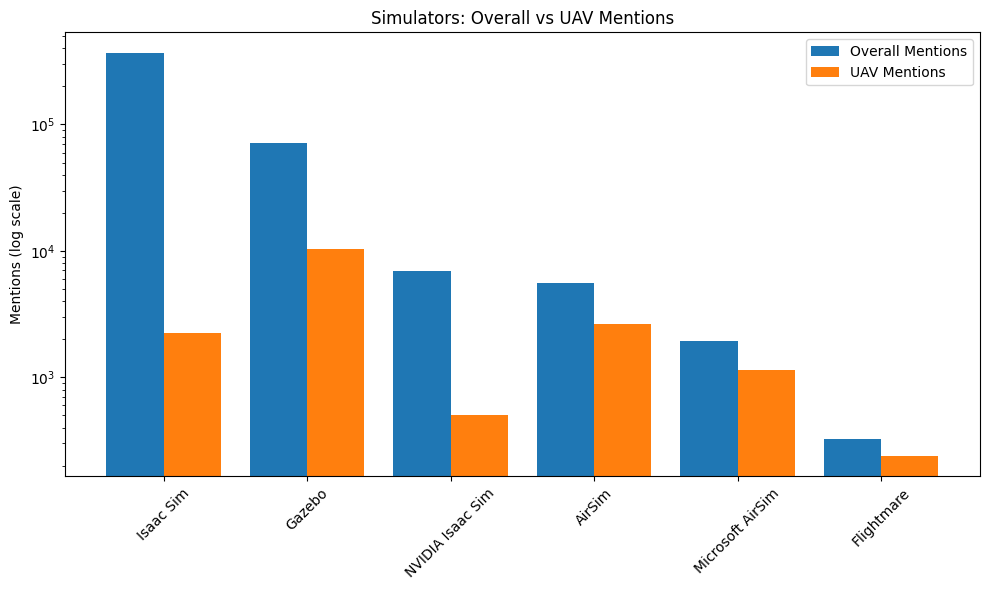

In [51]:
bar_chart_sims_by_overall_and_uav_mentions()

'Isaac Sim' search probably captures also plenty of unrelevant results, since 'NVIDIA Isaac Sim' got half less results. The same seems to happen with 'AirSim' and 'Microsoft AirSim' but to a lesser extent.

Gazebo is old and the most popular simulator in research.

PX4 and ArduPilot are the most popular and primarily used for UAVs.

Flightmare is quiet new and not so wide-spread yet.

In [52]:
def stacked_bar_chart_sim_mentions_with_software_breakdown(
    df, title, index, legend_title
):
    df.set_index(index, inplace=True)
    df.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")

    plt.ylabel("Percentage Mentions")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title=legend_title)
    plt.tight_layout()
    plt.savefig(f"{folder_to_save_plots}/{title}.png")

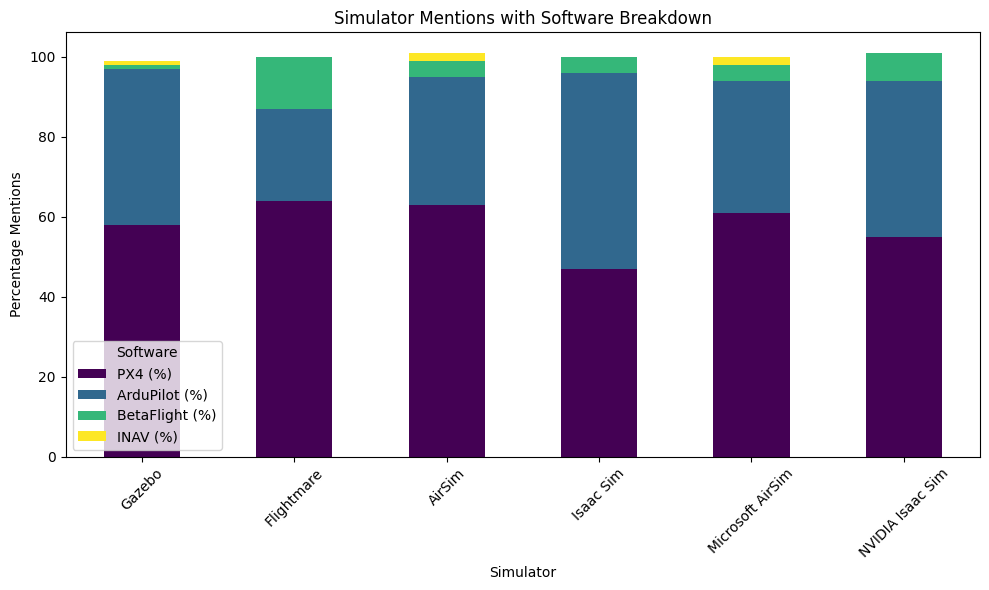

In [61]:
software_simulators_df = pd.DataFrame(get_software_in_simulators())
stacked_bar_chart_sim_mentions_with_software_breakdown(
    software_simulators_df,
    "Simulator Mentions with Software Breakdown",
    index="Simulator",
    legend_title="Software",
)

Most simulators tend to use PX4, with the exception of Microsoft AirSim, which is slightly more commonly coupled with ArduPilot.

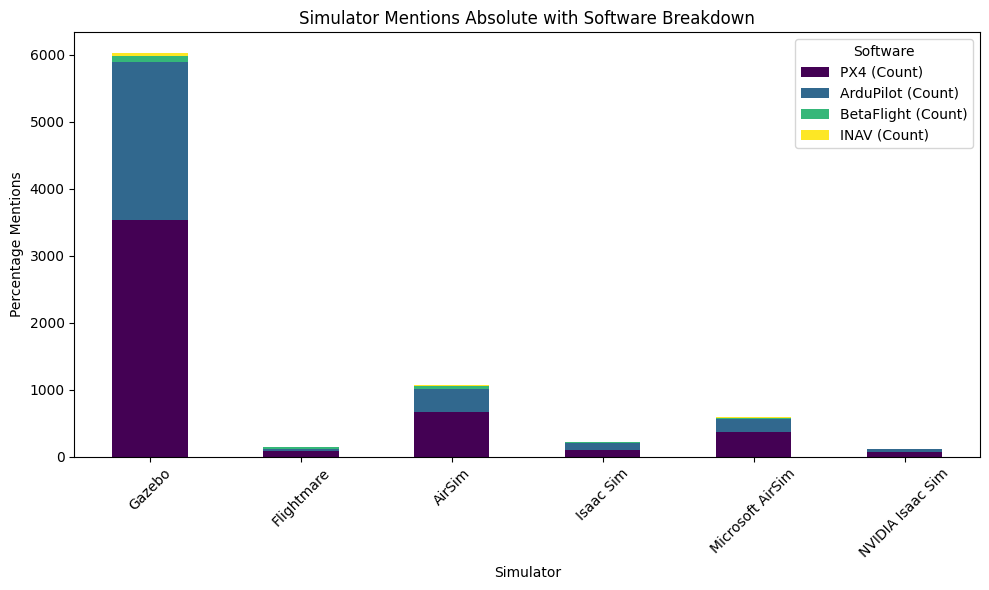

In [54]:
# ABSOLUTE VALUES

software_simulators_df_abs = pd.DataFrame(get_software_in_simulators_absolute())
stacked_bar_chart_sim_mentions_with_software_breakdown(
    software_simulators_df_abs,
    "Simulator Mentions Absolute with Software Breakdown",
    index="Simulator",
    legend_title="Software",
)

This data has a bit different values for simulators than 'Simulators: Overall vs UAV Mentions' plot since the overall count on this plot is a sum of searched flight control software usage (PX4, ArduPilot etc.). So it is expected that there are papers about the simulator and UAVs but without mentions of any of chosen control software.

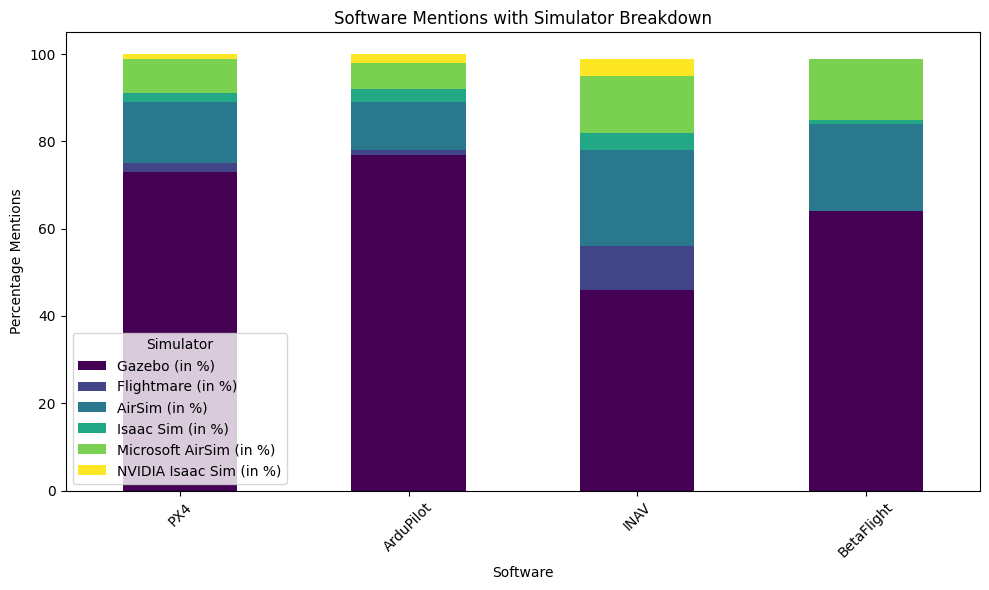

In [55]:
simulators_software_df = pd.DataFrame(get_simulators_in_software())
stacked_bar_chart_sim_mentions_with_software_breakdown(
    simulators_software_df,
    "Software Mentions with Simulator Breakdown",
    index="Software",
    legend_title="Simulator",
)

Most flight software is used on Gazebo.

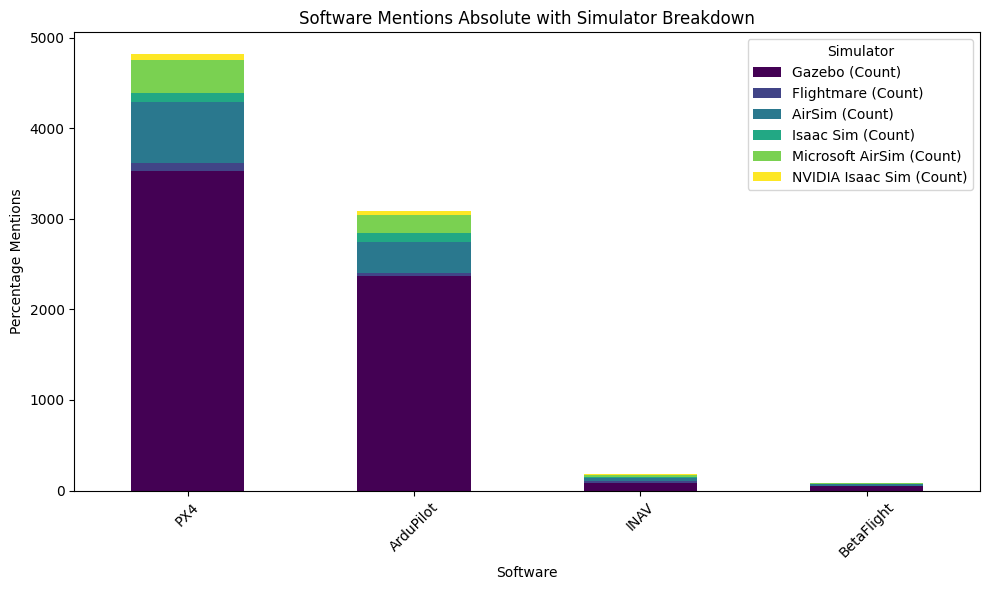

In [62]:
# ABSOLUTE VALUES

simulators_software_df_abs = pd.DataFrame(get_simulators_in_software_absolute())
stacked_bar_chart_sim_mentions_with_software_breakdown(
    simulators_software_df_abs,
    "Software Mentions Absolute with Simulator Breakdown",
    index="Software",
    legend_title="Simulator",
)

INAV and BetaFlight are significantly less popular in research than PX4 and ArduPilot.

In [57]:
def heatmap_software_mentions_across_sims(df, title, xlabel, ylabel, rotate_xs=False):
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df,
        annot=True,
        fmt="d",
        cmap="YlGnBu",
        linewidths=0.5,
        cbar_kws={"label": "Percentage Mentions"},
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.xticks(rotation=45 if rotate_xs else 0)
    plt.savefig(f"{folder_to_save_plots}/{title}.png")

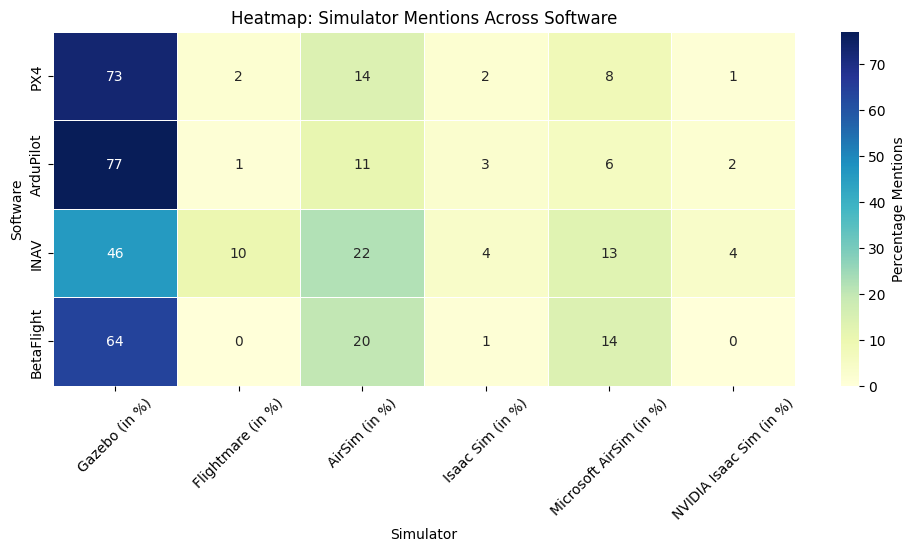

In [58]:
heatmap_software_mentions_across_sims(
    simulators_software_df,
    "Heatmap: Simulator Mentions Across Software",
    xlabel="Simulator",
    ylabel="Software",
    rotate_xs=True,
)

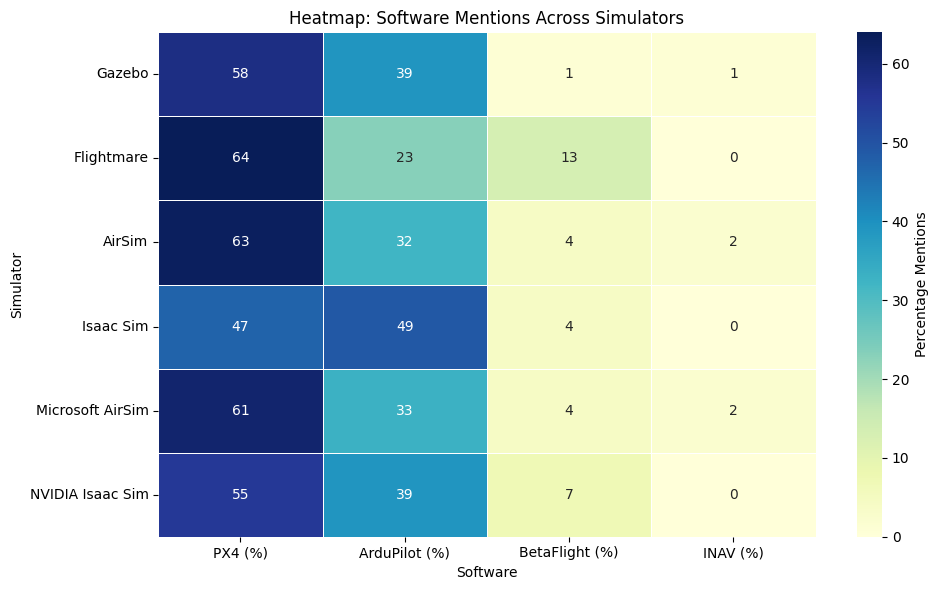

In [63]:
heatmap_software_mentions_across_sims(
    software_simulators_df,
    "Heatmap: Software Mentions Across Simulators",
    xlabel="Software",
    ylabel="Simulator",
)